In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/UTKFace.zip" -d "/content/UTKFace"

In [3]:
import os
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, accuracy_score
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
from tensorflow.keras.losses import Huber
import pandas as pd
import keras


In [4]:
DATA_DIR = "/content/UTKFace/UTKFace"

# Répartition des âges

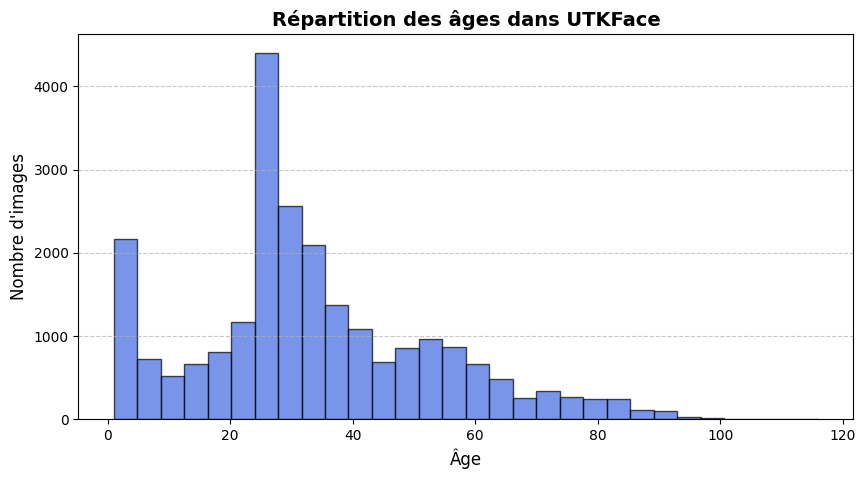

In [5]:
# Extraction des âges depuis le nom des fichiers
ages = []
for filename in os.listdir(DATA_DIR):
    try:
        age = int(filename.split("_")[0])  # Extraction de l'âge (1ère partie du nom de fichier)
        ages.append(age)
    except ValueError:
        pass  # Ignorer les fichiers mal formatés

# Création de l'histogramme
plt.figure(figsize=(10, 5))
plt.hist(ages, bins=30, color="royalblue", edgecolor="black", alpha=0.7)

# Personnalisation du graphique
plt.title("Répartition des âges dans UTKFace", fontsize=14, fontweight="bold")
plt.xlabel("Âge", fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Affichage
plt.show()


L'un des principaux défis de ce modèle est la distribution déséquilibrée des âges dans le dataset.

L'histogramme montre une concentration d'images autour de 20 ans, tandis que les extrêmes (0-3 ans et 80+ ans) sont sous-représentés.

Cela risque d'entraîner un biais du modèle en faveur des classes d'âge majoritaires, réduisant ainsi sa capacité à bien généraliser sur les tranches d'âge moins fréquentes.

Ensuite, le choix de la régression pour prédire un âge exact représente un défi supplémentaire. La variabilité de l’âge et la difficulté à obtenir une prédiction précise augmentent le risque d'erreurs élevées (ex. confondre un individu de 30 ans avec un de 50 ans est plus problématique que de prédire 10 ans au lieu de 12).

Enfin, un dernier point à ne pas négliger est la présence de biais dans le dataset, notamment liés au sexe et à l’ethnie, pouvant affecter la capacité du modèle à généraliser sur différentes populations.

# Traitement des images

In [6]:
#Redimensionnement
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [7]:
def load_data_age(data_dir=DATA_DIR, img_size=(64,64)):
    X = []
    y = []
    file_names = os.listdir(data_dir)

    for file in file_names:
        parts = file.split("_")
        if len(parts) > 1:
            try:
                age = int(parts[0])
            except:
                continue

            img_path = os.path.join(data_dir, file)
            img = cv2.imread(img_path)
            if img is None:
                continue

            # RGB + Resize + Normalisation
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img.astype("float32") / 255.0

            X.append(img)
            y.append(age)

    return np.array(X), np.array(y)

X, y = load_data_age(DATA_DIR, (IMG_HEIGHT, IMG_WIDTH))
print("Nombre d'images chargées :", len(X))
print("Dimension de X :", X.shape, "Dimension de y :", y.shape)

# Split Train / Val / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42
)

print("Taille du jeu d'entraînement :", X_train.shape, len(y_train))
print("Taille du jeu de validation :", X_val.shape, len(y_val))
print("Taille du jeu de test :", X_test.shape, len(y_test))


Nombre d'images chargées : 23708
Dimension de X : (23708, 64, 64, 3) Dimension de y : (23708,)
Taille du jeu d'entraînement : (15172, 64, 64, 3) 15172
Taille du jeu de validation : (3794, 64, 64, 3) 3794
Taille du jeu de test : (4742, 64, 64, 3) 4742


# Définition des tranches d'âges

In [8]:
# Définition des Tranches d'Âge
age_brackets = [
    (0,3), (4,9), (10,19), (20,29), (30,39),
    (40,49), (50,59), (60,69), (70,79), (80,116)
]